In [16]:
%matplotlib inline

In [17]:
import argparse
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance

import torch
import cpc.feature_loader as fl
import cpc.train as tr
from cpc.dataset import AudioBatchData, findAllSeqs, filterSeqs, parseSeqLabels
from cpc.utils.misc import jhuBoundaryDetector, jchBoundaryDetector, kreukBoundaryDetector

In [18]:
sys.path.append(os.path.dirname(tr.__file__))

In [19]:
onEncodings = True

# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/cpc-kreuk/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/cpc-kreuk-1neg/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-hierarchical-smartpooling10/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-hierarchical-ground-truth-segmentation/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-baseline2/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-baseline-cosine/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-hierarchical-smartpooling10-cosine/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-hierarchical-ground-truth-segmentation-cosine/checkpoint_30.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/cpc-kreuk-1neg-timit-cosine-norelu/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/cpc-kreuk-1neg-timit-norelu/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-baseline-cosine-timit/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-baseline-timit/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-hierarchical-smartpooling10-cosine-timit/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-hierarchical-smartpooling10-cosine-norelu-timit/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-baseline-timit/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/hacpc-gt-cosine-norelu-encodeseg-long-buckeye/checkpoint_49.pt'
CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/hacpc-gt-cosine-encodeseg-long-buckeye/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/zelasko-buck+ls/checkpoint_49.pt'

In [20]:
cdata = fl.getCheckpointData(os.path.dirname(CP))
_, _, args = cdata
model, args.hiddenGar, args.hiddenEncoder = fl.loadModel([CP])
assert args.speakerEmbedding == 0

try:
    criterion = tr.loadCriterion(CP, model.gEncoder.DOWNSAMPLING, len(speakers), None)
except:
    criterion = None
    print("Failed to load criterion :(((())))")

Loading checkpoint /pio/scratch/1/i323106/wav2vec/runs/cpc/hacpc-gt-cosine-encodeseg-long-buckeye/checkpoint_49.pt
LocArgs: Namespace(CPCCTC=True, CPCCTCLearnBlank=False, CPCCTCLossTemp=1.0, CPCCTCMasq='', CPCCTCNoNegsMatchWin=False, CPCCTCNormalizeEncs=False, CPCCTCNormalizePreds=False, CPCCTCNumLevels=2, CPCCTCNumMatched=12, CPCCTCSelfLoop=False, CPCCTCSkipBeg=0, CPCCTCSkipEnd=0, CTC=False, CTCphones=False, abspos=False, arMode='LSTM', batchSizeGPU=16, beta1=0.9, beta2=0.999, captureCPCCTCalign=False, captureCPCCTClogScores=False, captureConvRepr=False, captureCtxRepr=False, captureDSfreq=None, captureDStotNr=None, captureEachEpochs=10, captureEverything=False, capturePhoneAlign=False, capturePred=False, captureSetStats=None, captureSpeakerAlign=False, cpc_mode=None, debug=False, dropout=True, encodeSegments=True, encoder_type='cpc', epsilon=1e-08, file_extension=['.wav'], gru_level=-1, headWeights=[1.0, 1.0], hiddenEncoder=256, hiddenGar=256, ignore_cache=True, learningRate=0.0002, 

In [21]:
phoneNames = [
    'SIL','SPN','S','UW','T','N','K','Y','Z','AO','AY','SH','W','NG','EY',
    'B','CH','OY','JH','D','ZH','G','UH','F','V','ER','AA','IH',
    'M','DH','L','AH','P','OW','AW','HH','AE','R','TH','IY','EH'
]
codes2phones = {i: j for (i, j) in enumerate(phoneNames)}

In [22]:
codes2phones

{0: 'SIL',
 1: 'SPN',
 2: 'S',
 3: 'UW',
 4: 'T',
 5: 'N',
 6: 'K',
 7: 'Y',
 8: 'Z',
 9: 'AO',
 10: 'AY',
 11: 'SH',
 12: 'W',
 13: 'NG',
 14: 'EY',
 15: 'B',
 16: 'CH',
 17: 'OY',
 18: 'JH',
 19: 'D',
 20: 'ZH',
 21: 'G',
 22: 'UH',
 23: 'F',
 24: 'V',
 25: 'ER',
 26: 'AA',
 27: 'IH',
 28: 'M',
 29: 'DH',
 30: 'L',
 31: 'AH',
 32: 'P',
 33: 'OW',
 34: 'AW',
 35: 'HH',
 36: 'AE',
 37: 'R',
 38: 'TH',
 39: 'IY',
 40: 'EH'}

In [23]:
args.pathDB = ['/pio/gluster/data/ls-train-clean-100/LibriSpeech/train-clean-100']
args.pathTrain = ['/pio/gluster/data/ls-train-clean-100/train_split.txt']
args.pathVal = ['/pio/gluster/data/ls-train-clean-100/test_split.txt']
args.pathPhone = '/pio/gluster/data/ls-train-clean-100/converted_aligned_phones.txt'
args.size_window = 20480
args.file_extension = ['.flac']
args.ignore_cache = True

seqNames, speakers = findAllSeqs(args.pathDB,
                                 extension=args.file_extension,
                                 loadCache=not args.ignore_cache)
phone_labels, n_phones = parseSeqLabels(args.pathPhone)

seq_val = filterSeqs(args.pathVal, seqNames)[:10]
db_val = AudioBatchData(args.pathDB, args.size_window, seq_val,
                        phone_labels, len(speakers))


837it [00:02, 289.99it/s]


Ran in an error while saving /pio/gluster/data/ls-train-clean-100/LibriSpeech/train-clean-100/_seqs_cache.txt: [Errno 13] Permission denied: '/pio/gluster/data/ls-train-clean-100/LibriSpeech/train-clean-100/_seqs_cache.txt'


10it [00:00, 181571.60it/s]

Checking length...
Done, elapsed: 0.014 seconds
Scanned 10 sequences in 0.01 seconds
1 chunks computed


Joining pool
Joined process, elapsed=0.134 secs


In [24]:
model.cpu()
if criterion is not None:
    criterion.cpu()
valLoader = db_val.getDataLoader(1, 'sequential', False, numWorkers=0)
dataIter = iter(valLoader)
batchData, label = next(dataIter)
with torch.no_grad():
    cFeature, encodedData, _ = model(batchData, None)
label = label['phone']
cFeature = cFeature[0]

In [25]:
EPS = 1e-7
features = (encodedData[:, :-1, :], encodedData[:, 1:, :]) if onEncodings else (cFeature[:, :-1, :], cFeature[:, 1:, :])
segmentationParamRange = np.arange(0.01, 0.15, 0.01)
toleranceInFrames = 2

diffs = torch.diff(label, dim=1)
phone_changes = torch.cat((torch.ones((label.shape[0], 1), device=label.device), diffs), dim=1)
trueBoundariesBatch = torch.nonzero(phone_changes.contiguous().view(-1), as_tuple=True)[0]
batchSize, seqLen, featureDim = features[0].size()
seqEndIdx = torch.arange(0, batchSize * seqLen + 1, seqLen)
trueBoundariesBatch = torch.unique(torch.cat((trueBoundariesBatch, seqEndIdx)), sorted=True).unsqueeze(0)

seqLens = torch.ones(batchSize, dtype=torch.int64, device=features[0].device) * seqLen
# For Kreuk
maxRval = 0
boundariesKreuk = None

for segmentationParam in segmentationParamRange:
    predictedBoundariesBatch = kreukBoundaryDetector(features, segmentationParam, seqLens)
    
    precisionCounter = 0
    recallCounter = 0
    numPredictedBounds = 0
    numTrueBounds = 0

    for predictedBoundaries, trueBoundaries in zip(predictedBoundariesBatch, trueBoundariesBatch):
        numPredictedBounds += len(predictedBoundaries)
        numTrueBounds += len(trueBoundaries)
        for predictedBoundary in predictedBoundaries:
            minDist = torch.min(torch.abs(trueBoundaries - predictedBoundary))
            precisionCounter += (minDist <= toleranceInFrames)
        for trueBoundary in trueBoundaries:
            minDist = torch.min(torch.abs(predictedBoundaries - trueBoundary))
            detected = (minDist <= toleranceInFrames)
            recallCounter += detected

    precision = precisionCounter / (numPredictedBounds + EPS)
    recall = recallCounter / (numTrueBounds + EPS)
    f1 = 2 * (precision * recall) / (precision + recall + EPS)
    os = recall / (precision + EPS) - 1
    r1 = np.sqrt((1 - recall) ** 2 + os ** 2)
    r2 = (-os + recall - 1) / (np.sqrt(2))
    rVal = 1 - (np.abs(r1) + np.abs(r2)) / 2
    
    if rVal > maxRval:
        boundariesKreuk = predictedBoundaries
        bestSegmentationParam = segmentationParam
        maxRval = rVal
        bestPrecision = precision
        bestRecall = recall
        bestF1 = f1
print("-"*50)
print("Kreuk")
print("-"*50)
print(f"Precision:\t{bestPrecision}")
print(f"Recall:\t{bestRecall}")
print(f"F1:\t{bestF1}")
print(f"R:\t{maxRval}")

# For JCh
maxRval = 0
boundariesJCh = None
for segmentationParam in segmentationParamRange:
    predictedBoundariesBatch = jchBoundaryDetector(features, segmentationParam, seqLens).unsqueeze(0)
    
    precisionCounter = 0
    recallCounter = 0
    numPredictedBounds = 0
    numTrueBounds = 0

    for predictedBoundaries, trueBoundaries in zip(predictedBoundariesBatch, trueBoundariesBatch):
        numPredictedBounds += len(predictedBoundaries)
        numTrueBounds += len(trueBoundaries)
        for predictedBoundary in predictedBoundaries:
            minDist = torch.min(torch.abs(trueBoundaries - predictedBoundary))
            precisionCounter += (minDist <= toleranceInFrames)
        for trueBoundary in trueBoundaries:
            minDist = torch.min(torch.abs(predictedBoundaries - trueBoundary))
            detected = (minDist <= toleranceInFrames)
            recallCounter += detected
    precision = precisionCounter / (len(predictedBoundaries) + EPS)
    recall = recallCounter / (len(trueBoundaries) + EPS)
    f1 = 2 * (precision * recall) / (precision + recall + EPS)
    os_ = recall / (precision + EPS) - 1
    r1 = np.sqrt((1 - recall) ** 2 + os_ ** 2)
    r2 = (-os_ + recall - 1) / (np.sqrt(2))
    rVal = 1 - (np.abs(r1) + np.abs(r2)) / 2
    if rVal > maxRval:
        boundariesJCh = predictedBoundaries
        maxRval = rVal
        bestPrecision = precision
        bestRecall = recall
        bestF1 = f1
print("-"*50)
print("JCh")
print("-"*50)
print(f"Precision:\t{bestPrecision}")
print(f"Recall:\t{bestRecall}")
print(f"F1:\t{bestF1}")
print(f"R:\t{maxRval}")

--------------------------------------------------
Kreuk
--------------------------------------------------
Precision:	1.0
Recall:	0.8235294222831726
F1:	0.9032257199287415
R:	0.8752163648605347
--------------------------------------------------
JCh
--------------------------------------------------
Precision:	1.0
Recall:	0.8235294222831726
F1:	0.9032257199287415
R:	0.8752163648605347


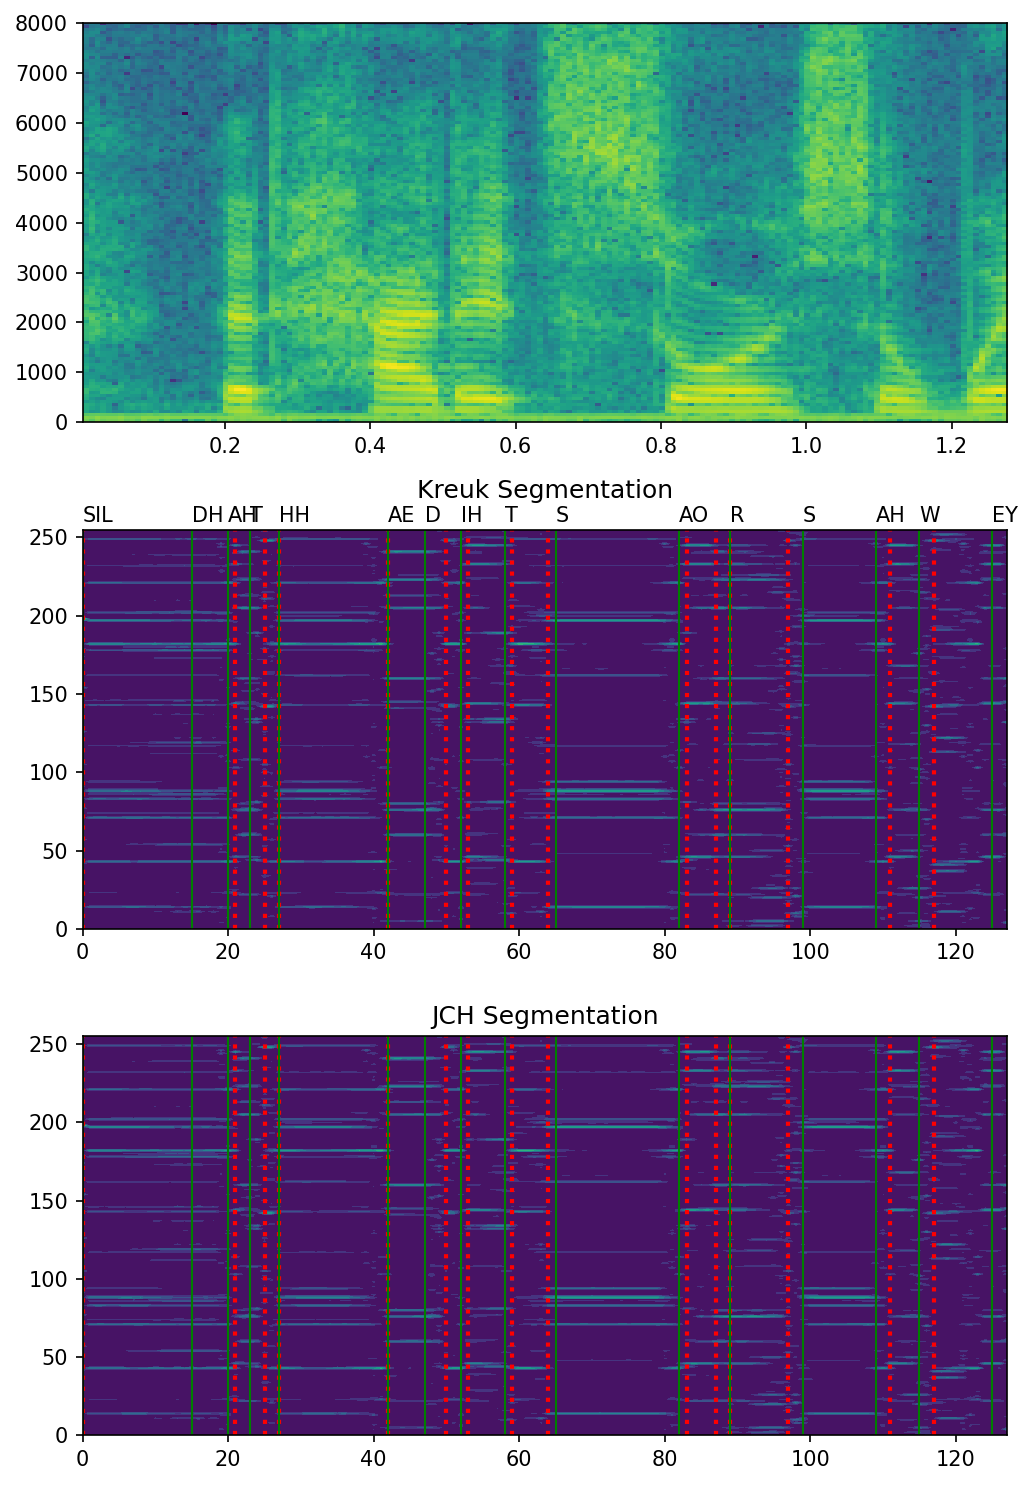

In [26]:
phones = label[0, trueBoundaries[:-1] + 1].numpy()
features = torch.cat((features[0], features[1][:, -1, :].unsqueeze(1)), dim=1)
enc = features[0, :None, :].detach().numpy()
enc = enc / np.sqrt((enc**2).sum(1, keepdims=True))
Z = enc.reshape(features.shape[1], features.shape[2]).T

waveform = batchData.cpu().numpy().reshape(-1)
x = np.arange(0, 128)
y = np.arange(0, 256)
X, Y = np.meshgrid(x, y)

plt.figure(figsize=(7, 10), dpi=150)
plt.subplot(311)
plt.specgram(waveform, Fs=16000)
plt.subplot(312)
plt.contourf(X, Y, Z, 10)
plt.vlines(x=boundariesKreuk.cpu().tolist()[:-1], ymin=0, ymax=255, colors='r', linewidth=2, linestyles=':')
plt.vlines(x=trueBoundaries.numpy().tolist()[:-1], ymin=0, ymax=255, colors='g', linewidth=1)
plt.title("Kreuk Segmentation", pad=15)
for p in range(len(phones)):
    plt.text(x=trueBoundaries[p], y = 260, s=codes2phones[phones[p]])
plt.subplot(313)
plt.contourf(X, Y, Z, 10)
plt.vlines(x=boundariesJCh.cpu().tolist()[:-1], ymin=0, ymax=255, colors='r', linewidth=2, linestyles=':')
plt.vlines(x=trueBoundaries.numpy().tolist()[:-1], ymin=0, ymax=255, colors='g', linewidth=1)
plt.title("JCH Segmentation")
plt.tight_layout()

# Buckeye

In [27]:
phones2codes = {  # phonemes which should be the same for TIMIT
    'a': 0, 'aa': 1, 'aan': 2, 'ae': 3, 'aen': 4, 'ah': 0, 'ahn': 5, 'an': 5, 
    'ao': 6, 'aon': 7, 'aw': 8, 'awn': 9, 'ay': 10, 'ayn': 11, 'b': 12, 'ch': 13, 
    'd': 14, 'dh': 15, 'dx': 16, 'eh': 17, 'ehn': 18, 'el': 19, 'em': 20, 'en': 21, 
    'eng': 22, 'er': 23, 'ern': 24, 'ey': 25, 'eyn': 26, 'f': 27, 'g': 28, 'h': 29, 
    'hh': 29, 'hhn': 30, 'i': 31, 'id': 31, 'ih': 31, 'ihn': 32, 'iy': 33, 'iyih': 32, 
    'iyn': 32, 'jh': 34, 'k': 35, 'l': 36, 'm': 37, 'n': 38, 'ng': 39, 'nx': 40, 
    'ow': 41, 'own': 42, 'oy': 43, 'oyn': 44, 'p': 45, 'q': 46, 'r': 47, 's': 48, 
    'sh': 49, 't': 50, 'th': 51, 'tq': 46, 'uh': 52, 'uhn': 53, 'uw': 54, 'uwix': 54, 
    'uwn': 55, 'v': 56, 'w': 57, 'y': 58, 'z': 59, 'zh': 60, '-': 61, '#': 62,
    'x': 63, 'no': 64
}

codes2phones = {v: k for k, v in phones2codes.items()}

In [28]:
args.pathDB = ['/pio/scratch/1/i323106/data/BUCKEYE/test/']
args.pathPhone = '/pio/scratch/1/i323106/data/BUCKEYE/converted_aligned_phones.txt'
args.size_window = 20480
args.file_extension = ['.wav']

seqNames, speakers = findAllSeqs(args.pathDB,
                                 extension=args.file_extension,
                                 loadCache=not args.ignore_cache)
phone_labels, n_phones = parseSeqLabels(args.pathPhone)

seq_val = seqNames[:10]
db_val = AudioBatchData(args.pathDB, args.size_window, seq_val,
                        phone_labels, len(speakers))

5it [00:00, 2599.02it/s]


Saved cache file at /pio/scratch/1/i323106/data/BUCKEYE/test/_seqs_cache.txt


10it [00:00, 176231.26it/s]

Checking length...
Done, elapsed: 0.004 seconds
Scanned 10 sequences in 0.00 seconds
1 chunks computed


Joining pool
Joined process, elapsed=0.366 secs


In [29]:
model.cpu()
if criterion is not None:
    criterion.cpu()
valLoader = db_val.getDataLoader(1, 'sequential', False, numWorkers=0)
dataIter = iter(valLoader)
batchData, label = next(dataIter)
with torch.no_grad():
    cFeature, encodedData, _ = model(batchData, None)
label = label['phone']
cFeature = cFeature[0]

In [33]:
EPS = 1e-7
features = (encodedData[:, :-1, :], encodedData[:, 1:, :]) if onEncodings else (cFeature[:, :-1, :], cFeature[:, 1:, :])
segmentationParamRange = np.arange(0.01, 0.15, 0.01)
toleranceInFrames = 2

diffs = torch.diff(label, dim=1)
phone_changes = torch.cat((torch.ones((label.shape[0], 1), device=label.device), diffs), dim=1)
trueBoundariesBatch = torch.nonzero(phone_changes.contiguous().view(-1), as_tuple=True)[0]
batchSize, seqLen, featureDim = features[0].size()
seqEndIdx = torch.arange(0, batchSize * seqLen + 1, seqLen)
trueBoundariesBatch = torch.unique(torch.cat((trueBoundariesBatch, seqEndIdx)), sorted=True).unsqueeze(0)

seqLens = torch.ones(batchSize, dtype=torch.int64, device=features[0].device) * seqLen
# For Kreuk
maxRval = 0
boundariesKreuk = None

for segmentationParam in segmentationParamRange:
    predictedBoundariesBatch = kreukBoundaryDetector(features, segmentationParam, seqLens)
    
    precisionCounter = 0
    recallCounter = 0
    numPredictedBounds = 0
    numTrueBounds = 0

    for predictedBoundaries, trueBoundaries in zip(predictedBoundariesBatch, trueBoundariesBatch):
        numPredictedBounds += len(predictedBoundaries)
        numTrueBounds += len(trueBoundaries)
        for predictedBoundary in predictedBoundaries:
            minDist = torch.min(torch.abs(trueBoundaries - predictedBoundary))
            precisionCounter += (minDist <= toleranceInFrames)
        for trueBoundary in trueBoundaries:
            minDist = torch.min(torch.abs(predictedBoundaries - trueBoundary))
            detected = (minDist <= toleranceInFrames)
            recallCounter += detected

    precision = precisionCounter / (numPredictedBounds + EPS)
    recall = recallCounter / (numTrueBounds + EPS)
    f1 = 2 * (precision * recall) / (precision + recall + EPS)
    os = recall / (precision + EPS) - 1
    r1 = np.sqrt((1 - recall) ** 2 + os ** 2)
    r2 = (-os + recall - 1) / (np.sqrt(2))
    rVal = 1 - (np.abs(r1) + np.abs(r2)) / 2
    
    if rVal > maxRval:
        boundariesKreuk = predictedBoundaries
        bestSegmentationParam = segmentationParam
        maxRval = rVal
        bestPrecision = precision
        bestRecall = recall
        bestF1 = f1
print("-"*50)
print("Kreuk")
print("-"*50)
print(f"Precision:\t{bestPrecision}")
print(f"Recall:\t{bestRecall}")
print(f"F1:\t{bestF1}")
print(f"R:\t{maxRval}")

# For JCh
maxRval = 0
boundariesJCh = None
for segmentationParam in segmentationParamRange:
    predictedBoundariesBatch = jchBoundaryDetector(features, segmentationParam, seqLens).unsqueeze(0)
    
    precisionCounter = 0
    recallCounter = 0
    numPredictedBounds = 0
    numTrueBounds = 0

    for predictedBoundaries, trueBoundaries in zip(predictedBoundariesBatch, trueBoundariesBatch):
        numPredictedBounds += len(predictedBoundaries)
        numTrueBounds += len(trueBoundaries)
        for predictedBoundary in predictedBoundaries:
            minDist = torch.min(torch.abs(trueBoundaries - predictedBoundary))
            precisionCounter += (minDist <= toleranceInFrames)
        for trueBoundary in trueBoundaries:
            minDist = torch.min(torch.abs(predictedBoundaries - trueBoundary))
            detected = (minDist <= toleranceInFrames)
            recallCounter += detected
    precision = precisionCounter / (len(predictedBoundaries) + EPS)
    recall = recallCounter / (len(trueBoundaries) + EPS)
    f1 = 2 * (precision * recall) / (precision + recall + EPS)
    os_ = recall / (precision + EPS) - 1
    r1 = np.sqrt((1 - recall) ** 2 + os_ ** 2)
    r2 = (-os_ + recall - 1) / (np.sqrt(2))
    rVal = 1 - (np.abs(r1) + np.abs(r2)) / 2
    if rVal > maxRval:
        boundariesJCh = predictedBoundaries
        maxRval = rVal
        bestPrecision = precision
        bestRecall = recall
        bestF1 = f1
print("-"*50)
print("JCh")
print("-"*50)
print(f"Precision:\t{bestPrecision}")
print(f"Recall:\t{bestRecall}")
print(f"F1:\t{bestF1}")
print(f"R:\t{maxRval}")

--------------------------------------------------
Kreuk
--------------------------------------------------
Precision:	0.9473684430122375
Recall:	0.949999988079071
F1:	0.9486823678016663
R:	0.956301748752594
--------------------------------------------------
JCh
--------------------------------------------------
Precision:	1.0
Recall:	0.699999988079071
F1:	0.8235293030738831
R:	0.7878679633140564


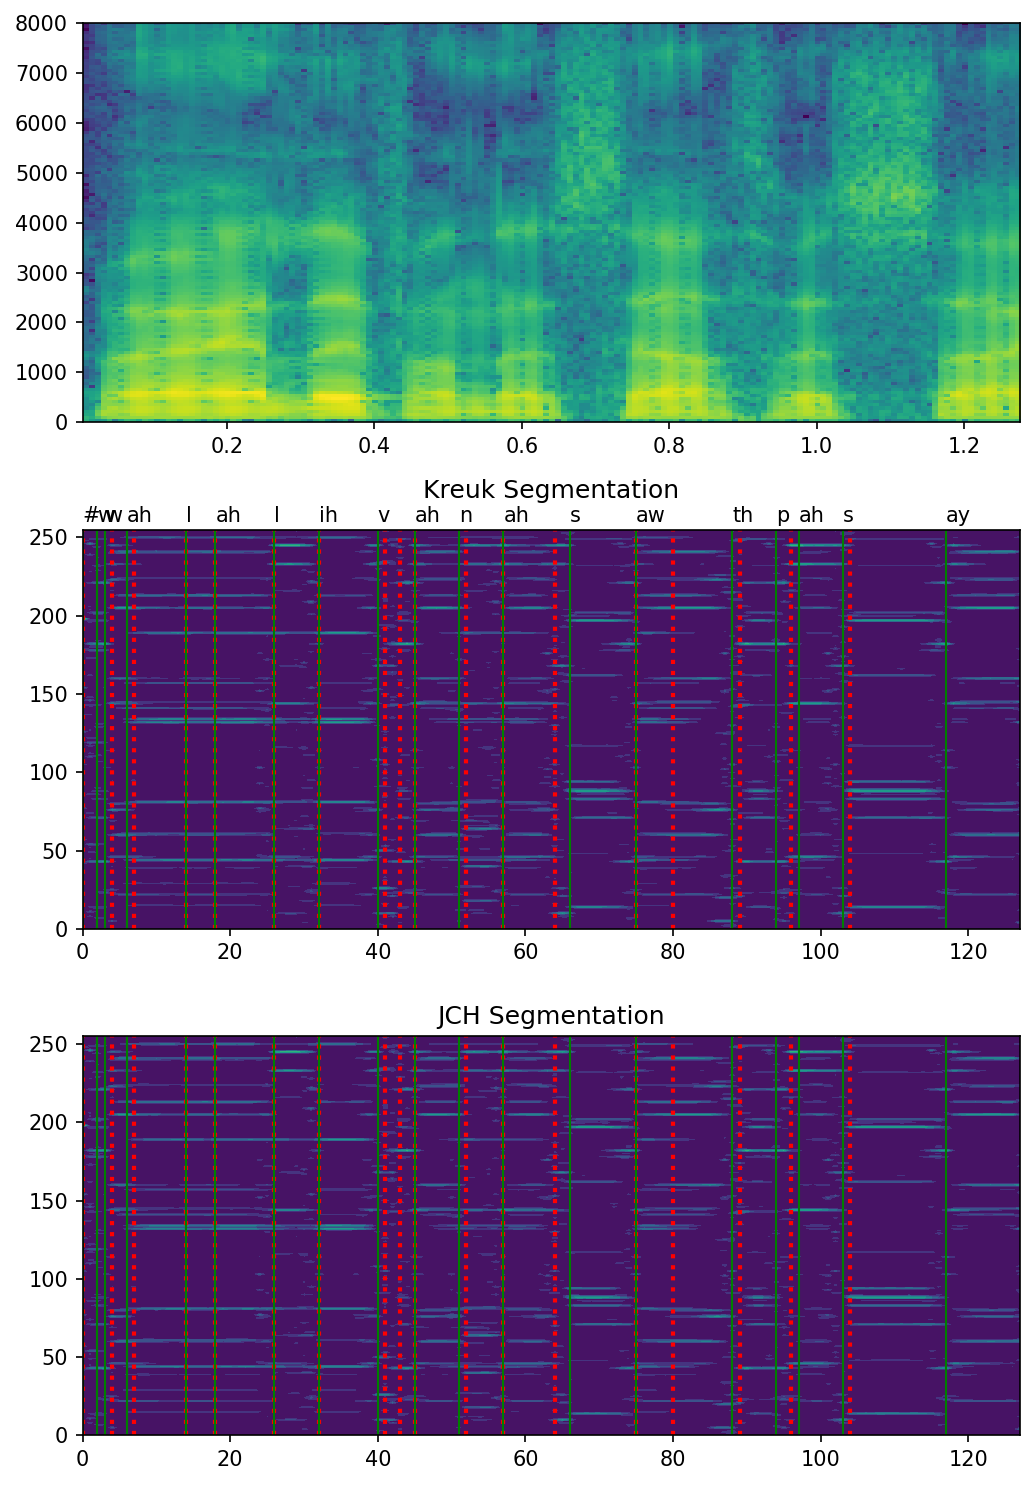

In [31]:
phones = label[0, trueBoundaries[:-1] + 1].numpy()
features = torch.cat((features[0], features[1][:, -1, :].unsqueeze(1)), dim=1)
enc = features[0, :None, :].detach().numpy()
enc = enc / np.sqrt((enc**2).sum(1, keepdims=True))
Z = enc.reshape(features.shape[1], features.shape[2]).T

waveform = batchData.cpu().numpy().reshape(-1)
x = np.arange(0, 128)
y = np.arange(0, 256)
X, Y = np.meshgrid(x, y)

plt.figure(figsize=(7, 10), dpi=150)
plt.subplot(311)
plt.specgram(waveform, Fs=16000)
plt.subplot(312)
plt.contourf(X, Y, Z, 10)
plt.vlines(x=boundariesKreuk.cpu().tolist()[:-1], ymin=0, ymax=255, colors='r', linewidth=2, linestyles=':')
plt.vlines(x=trueBoundaries.numpy().tolist()[:-1], ymin=0, ymax=255, colors='g', linewidth=1)
plt.title("Kreuk Segmentation", pad=15)
for p in range(len(phones)):
    plt.text(x=trueBoundaries[p], y = 260, s=codes2phones[phones[p]])

plt.subplot(313)
plt.contourf(X, Y, Z, 10)
plt.vlines(x=boundariesJCh.cpu().tolist()[:-1], ymin=0, ymax=255, colors='r', linewidth=2, linestyles=':')
plt.vlines(x=trueBoundaries.numpy().tolist()[:-1], ymin=0, ymax=255, colors='g', linewidth=1)
plt.title("JCH Segmentation")
plt.tight_layout()